# Large Scale Bayesian Inference of Log-Gaussian Cox Processes with Expectation Propagation for Traffic Density Estimation Problem

Use Environment: lgcp

# Generate road scenario

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from gp import sample_from_GP
from tikzplotlib import save as tikz_save

In [2]:
# Road geometry
segment_length = 0.2 # meters
n_segments = 2 # number of segments
xs = np.linspace(0, segment_length * n_segments, n_segments)

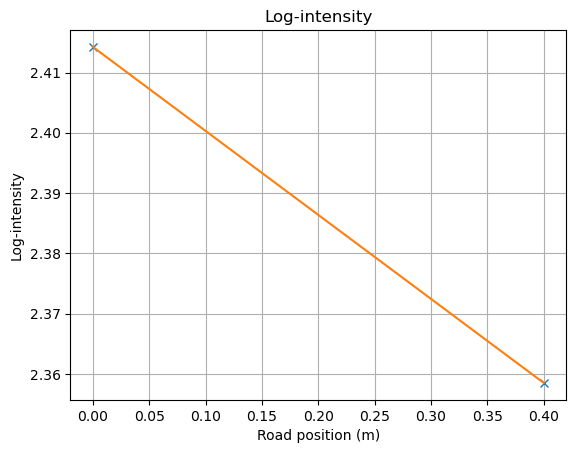

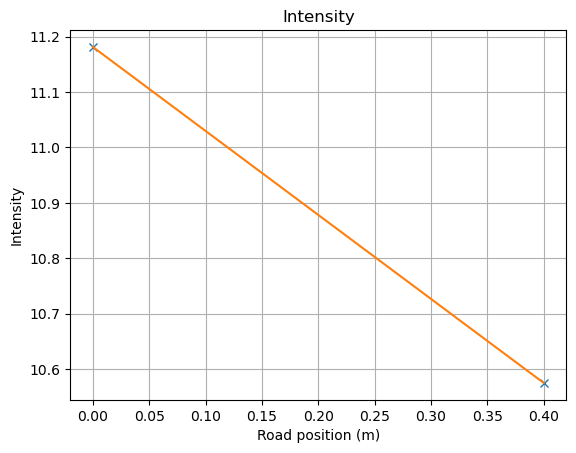

In [3]:
# Sample the log-intensity from GP
np.random.seed(6969)
log_intensity = sample_from_GP(xs, mean=2, var=5e-2, l=1)
plt.plot(xs, log_intensity, 'x')
plt.plot(xs, log_intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Log-intensity')
plt.title('Log-intensity')
plt.grid()
# intensity
intensity = np.exp(log_intensity)
plt.figure()
plt.plot(xs, intensity, 'x')
plt.plot(xs, intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Intensity')
plt.title('Intensity')
plt.grid()

In [4]:
print('Log-intensity: ', log_intensity)
print('Intensity: ', intensity)

Log-intensity:  [2.41424309 2.35850458]
Intensity:  [11.18130396 10.57512537]


In [5]:
# Sample vehicle positions from intensity using Poisson point process
n_vehicles = []
vehicle_positions = []
for segment in range(n_segments):
    # Sample number of vehicles in segment
    segment_n_vehicles = np.random.poisson(intensity[segment])
    # Add to list
    n_vehicles.append(segment_n_vehicles)
    # Sample vehicle positions in segment
    segment_vehicle_positions = np.random.uniform(0, segment_length, segment_n_vehicles)
    # Add segment offset
    segment_vehicle_positions += segment * segment_length
    # Add to list
    vehicle_positions.extend(segment_vehicle_positions)

# Convert to numpy array
vehicle_positions = np.array(vehicle_positions)
n_vehicles = np.array(n_vehicles)


# Generate measurements

Text(0.5, 1.0, 'Measurement Positions')

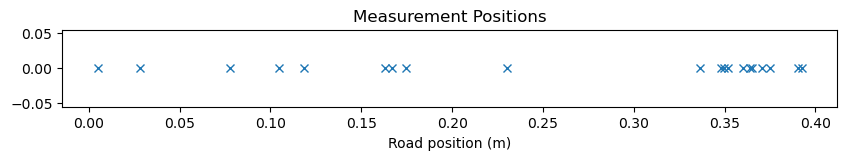

In [6]:
# Generate 20 measurements 
n_measurements = 20
max_road_position = n_segments * segment_length
measurement_positions = np.random.uniform(0, max_road_position, n_measurements)
plt.figure(figsize=(10, 1))
plt.plot(measurement_positions, np.zeros_like(measurement_positions), 'x')
plt.xlabel('Road position (m)')
plt.title('Measurement Positions')

In [7]:
measurement_range = 0.1
measurement_segment_counts = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement
measurement_segment_counts_extrapolated = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement, extrapolated with the segment length
for i, measurement_position in enumerate(measurement_positions):
    # List all the vehicles in the measurement range
    in_range_bools = np.logical_and(vehicle_positions > measurement_position - measurement_range, vehicle_positions < measurement_position + measurement_range) # boolean array of all vehicles: True if in range
    in_range = vehicle_positions[in_range_bools] # list of vehicle positions in range
    # Count the number of vehicles in each segment
    segment_counts = np.zeros((n_segments,))
    segment_counts_extrapolated = np.zeros((n_segments,))
    for segment in range(n_segments):
        segment_counts[segment] = np.sum(np.logical_and(in_range > segment * segment_length, in_range < (segment + 1) * segment_length))
        if segment_counts[segment] > 0:
            # Find the length of the intersection between the segment and the measurement range
            segment_start = segment * segment_length
            segment_end = (segment + 1) * segment_length
            intersection_start = max(segment_start, measurement_position - measurement_range)
            intersection_end = min(segment_end, measurement_position + measurement_range)
            intersection_length = intersection_end - intersection_start
            # Extrapolate the number of vehicles in the segment using the intersection length
            segment_counts_extrapolated[segment] = segment_counts[segment] * segment_length / intersection_length
    measurement_segment_counts[i, :] = segment_counts
    measurement_segment_counts_extrapolated[i, :] = segment_counts_extrapolated

In [8]:
print('Meausrement Segment Counts Extrapolated (1 line = 1 measurement):\n', measurement_segment_counts_extrapolated)
print('Actual Segment Counts (1 line = 1 measurement):\n', n_vehicles)

Meausrement Segment Counts Extrapolated (1 line = 1 measurement):
 [[ 0.         14.59435088]
 [ 0.         13.15049282]
 [13.21395481  0.        ]
 [13.52682798  5.97629424]
 [ 0.         13.45238971]
 [ 9.35415404  0.        ]
 [11.44659949  0.        ]
 [ 0.         13.27864433]
 [20.036464    9.22173252]
 [ 0.         14.37069282]
 [ 0.         13.88303158]
 [ 0.         12.85435789]
 [12.29635043  0.        ]
 [13.51261269  0.        ]
 [ 0.         13.32689968]
 [13.13487987  6.35320991]
 [ 0.         14.90494741]
 [12.76919338  5.35486501]
 [ 0.         13.21289792]
 [ 0.         12.15367627]]
Actual Segment Counts (1 line = 1 measurement):
 [13 11]


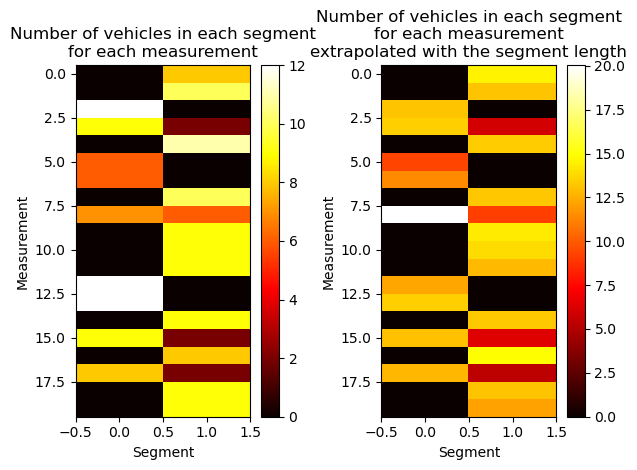

In [9]:
# Visualize the measurements
plt.subplot(1, 2, 1)
plt.imshow(measurement_segment_counts, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(measurement_segment_counts_extrapolated, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement\nextrapolated with the segment length')
plt.colorbar()
plt.tight_layout()

# Inference

Posterior update for normal distributions

In [10]:
# Gaussian distribution posterior update
def gaussian_posterior_update_scalar(mean1, var1, mean2, var2):
    prec1 = 1/var1
    prec2 = 1/var2
    var = 1/(prec1 + prec2)
    # print('var1 = {}'.format(var1[:3,:3]))
    mean = var * (prec1 * mean1 + prec2 * mean2)
    # print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update(mean1, var1, mean2, var2, use_moore_penrose=True):
    if use_moore_penrose:
        prec1 = np.linalg.pinv(var1)
        prec2 = np.linalg.pinv(var2)
    else:
        prec1 = np.linalg.inv(var1)
        prec2 = np.linalg.inv(var2)
    var = np.linalg.inv(prec1 + prec2)
    # print('var1 = {}'.format(var1[:3,:3]))
    mean = var @ (prec1 @ mean1 + prec2 @ mean2)
    # print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update_list(means, vars, use_moore_penrose=True):
    mean = means[0,:]
    var = vars[0,:,:]
    for i in range(1, means.shape[0]):
        # print('Iter B {}: mean = {}'.format(i, mean[:5]))
        mean, var = gaussian_posterior_update(mean, var, means[i,:], vars[i,:,:], use_moore_penrose=use_moore_penrose)
        # print('Iter A {}: mean = {}'.format(i, mean[:5]))
    return mean, var

Laplace approximation for Normal-Poisson observation model

In [11]:
def laplace_mean_through_fpi(rho_j, C_tilde_star, nj, mu_tilde_star, A, max_iter=100, tol=1e-9, verbose=False):
    y = np.zeros_like(mu_tilde_star) # initialize y
    one_j = np.zeros_like(mu_tilde_star)
    one_j[rho_j] = 1
    if verbose:
        print('Fixed Point Iteration for Laplace Mean started')
    for iter in range(max_iter):
        if verbose:
            print('Starting from y: {}'.format(y[:5]))
        y_new = mu_tilde_star + C_tilde_star @ ((nj - A*np.exp(y)) * one_j)
        if verbose:
            print('Delta y: {}'.format(C_tilde_star @ ((nj - A*np.exp(y)) * one_j)))
        if np.linalg.norm(y_new - y) < tol:
            if verbose:
                print('Converged')
                print('Error: {}'.format(np.linalg.norm(y_new-y)))
            break
        y = y_new
        if verbose:
            print('=>Iteration {}, y: {}'.format(iter, y[:5]))
            print('-----------------')
    
    if iter == max_iter - 1:
        print('WARNING: Fixed Point Iteration for Laplace Mean did not converge after {} iterations'.format(max_iter))
        print('Error: {}'.format(np.linalg.norm(y_new-y)))
    return y_new

def laplace_mean_through_newton(rho_j, C_tilde_star, nj, mu_tilde_star, A, max_iter=100, tol=1e-9, verbose=False):
    y = np.zeros_like(mu_tilde_star) # initialize y
    one_j = np.zeros_like(mu_tilde_star)
    one_j[rho_j] = 1
    P_tilde_star = np.linalg.pinv(C_tilde_star)

    if verbose:
        print('=== Newton Iteration for Laplace Mean started ===')
    for iter in range(max_iter):
        if verbose:
            print('Starting from y: {}'.format(y[:5]))
        # Compute the Jacobian matrix
        Z = np.zeros((len(y), len(y)))
        Z[:, rho_j] = -P_tilde_star[:,rho_j] * A * np.exp(y[rho_j])
        Df = -np.eye(len(y)) + Z
        
        # Newton update step
        y_new = y - np.linalg.pinv(Df) @ (-y + mu_tilde_star + P_tilde_star @ ((nj - A*np.exp(y[rho_j])) * one_j))
        if verbose:
            print('Df:\n', Df)
            print('Delta y: {}'.format(y_new - y))
        if np.linalg.norm(y_new - y) < tol:
            if verbose:
                print('Converged')
                print('Error: {}'.format(np.linalg.norm(y_new-y)))
            break
        y = y_new
        if verbose:
            print('=> Iteration {}, y: {}'.format(iter, y[:5]))
            print('-----------------')
    
    if iter == max_iter - 1:
        print('WARNING: Newton Iteration for Laplace Mean did not converge after {} iterations'.format(max_iter))
        print('Error: {}'.format(np.linalg.norm(y_new-y)))

    if verbose:
        print('=== Newton Iteration for Laplace Mean ended ===')
    return y_new

def laplace_var(rho_j, C_tilde_star, A, y, verbose=False):
    res = -np.linalg.inv(C_tilde_star)
    res[rho_j, rho_j] -= A*np.exp(y[rho_j])
    return -np.linalg.inv(res)

Expectation Propagation

In [12]:
from gp import gram_matrix
# Expectation Propagation (EP)

# Initialize the EP parameters
# Intractable component approximators / log-likelihood
mu_tildes = np.zeros((n_measurements, n_segments))
var_tildes = np.zeros((n_measurements, n_segments, n_segments))
for i in range(n_measurements):
    # var_tildes[i, :, :] = np.eye(n_segments) * 1e-3
    var_tildes[i, :, :] = np.zeros((n_segments, n_segments)) 

# Tractable components approximator / prior
mu_zero = np.ones((n_segments,)) * 0.5
# var_zero = gram_matrix(xs, var=5e-1, l=2)
var_zero = np.eye(n_segments) * 1e-1

In [13]:
from tqdm import tqdm

# Algorithm Hyperparameters
max_ep_iterations = 100
verbose = True
np.random.seed(6969)
use_moore_penrose = True
update_natural_params = True

# Output variables history through the iterations
mu_tildes_history = np.zeros((max_ep_iterations, n_measurements, n_segments))
var_tildes_history = np.zeros((max_ep_iterations, n_measurements, n_segments, n_segments))
mu_posterior_history = np.zeros((max_ep_iterations, n_segments))
var_posterior_history = np.zeros((max_ep_iterations, n_segments, n_segments))

for ep_iteration in (pbar := tqdm(range(max_ep_iterations))):
    
    # Choose a random measurement index j component to refine
    j = np.random.randint(0, n_measurements)
    
    # ==================    q_minus_j    ==================
    q_minus_j_means_param = np.concatenate((mu_zero.reshape((1,-1)), np.delete(mu_tildes, j, axis=0)))
    q_minus_j_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), np.delete(var_tildes, j, axis=0)))
    mu_q_minus_j, var_q_minus_j = gaussian_posterior_update_list(means = q_minus_j_means_param, vars = q_minus_j_vars_param, use_moore_penrose=use_moore_penrose)
    
    # ==================    Tilted Distribution    ==================
    measurement_segment_counts_extrapolated_j = measurement_segment_counts_extrapolated[j, :]
    # Segment index is the first non-zero element
    segment_index_j = np.argmax(measurement_segment_counts_extrapolated_j > 0)
    # Number of vehicles in the segment
    nj = measurement_segment_counts_extrapolated_j[segment_index_j]
    # Rename the variables so that they are consistent with the paper
    # q_minus_j's covariance matrix and mean vector
    C_tilde_star = var_q_minus_j
    mu_tilde_star = mu_q_minus_j
    # A is the segment length
    A = 1 # TODO: Change this to the actual segment length
    # Index of the segment to be updated with Laplace approximation
    rho_j = segment_index_j

    # Print the parameters
    if verbose:
        print('=== Tilted Distribution Parameters ===')
        print('j / Index of Measurement: {}'.format(j))
        print('rho_j / Index of Segment: {}'.format(rho_j))
        print('nj / Segment Count: {}'.format(nj))
        print('A / Segment Length (**assumed to be 1**): {}'.format(A))
        print('mu_tilde_star / q_minus_j mean: {}'.format(mu_tilde_star[:5]))
        print('C_tilde_star / q_minus_j var:\n{}'.format(C_tilde_star[:5,:5]))
        print('=======================================')
    
    # ==================    Laplace Approximation of Tilted Distribution    ==================
    lmean = laplace_mean_through_newton(rho_j, C_tilde_star, nj, mu_tilde_star, A, verbose=True)
    lvar = laplace_var(rho_j, C_tilde_star, A, lmean, verbose=False)
    
    # ==================    Update the EP parameters    ==================
    
    # Derive the natural parameters of the jth intractable component
    # The precision matrices
    
    if use_moore_penrose:
        lvar_inv = np.linalg.pinv(lvar)
        C_tilde_star_inv = np.linalg.pinv(C_tilde_star)
        iter_var_difference_inv = lvar_inv - C_tilde_star_inv
        iter_var_difference = np.linalg.pinv(iter_var_difference_inv)
    else:
        lvar_inv = np.linalg.inv(lvar)
        C_tilde_star_inv = np.linalg.inv(C_tilde_star)
        iter_var_difference_inv = lvar_inv - C_tilde_star_inv
        iter_var_difference = np.linalg.inv(iter_var_difference_inv)

    iter_mean_difference = iter_var_difference @ (lvar_inv @ lmean - C_tilde_star_inv @ mu_tilde_star)
    
    # Update the EP parameters
    if update_natural_params:
        mu_tildes[j, :] = iter_mean_difference # replace the jth intractable component with Laplace mean
        var_tildes[j, :, :] = iter_var_difference
    
    if verbose:
        print('-----------------')
        print('Mean imitator set to: {}'.format(mu_tildes[j, :]))
        print('Var imitator set to:\n{}'.format(var_tildes[j, :, :]))
        print('-----------------')
        print('Laplace mean: {}'.format(lmean))
        print('Laplace var:\n{}'.format(lvar))
        print('-----------------')

    # Calculate the posterior distribution
    q_means_param = np.concatenate((mu_zero.reshape((1,-1)), mu_tildes))
    q_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), var_tildes))
    mu_q, var_q = gaussian_posterior_update_list(means = q_means_param, vars = q_vars_param)
    # Store the posterior parameters in the history variables
    mu_tildes_history[ep_iteration, :, :] = mu_tildes
    var_tildes_history[ep_iteration, :, :, :] = var_tildes
    mu_posterior_history[ep_iteration, :] = mu_q
    var_posterior_history[ep_iteration, :, :] = var_q
    
    # Show the difference between subsequent iterations, also a condition for convergence
    delta_diff_of_mean = np.linalg.norm(iter_mean_difference)
    tqdm.set_description(pbar, 'Delta diff of mean: {}'.format(delta_diff_of_mean))

Delta diff of mean: 2.8291921051894926:  33%|███▎      | 33/100 [00:00<00:00, 160.08it/s] 

=== Tilted Distribution Parameters ===
j / Index of Measurement: 18
rho_j / Index of Segment: 1
nj / Segment Count: 13.2128979208493
A / Segment Length (**assumed to be 1**): 1
mu_tilde_star / q_minus_j mean: [0.5 0.5]
C_tilde_star / q_minus_j var:
[[0.1 0. ]
 [0.  0.1]]
=== Newton Iteration for Laplace Mean started ===
Starting from y: [0. 0.]
Df:
 [[ -1.  -0.]
 [  0. -11.]]
Delta y: [ 0.5        11.14808902]
=> Iteration 0, y: [ 0.5        11.14808902]
-----------------
Starting from y: [ 0.5        11.14808902]
Df:
 [[-1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -6.94311199e+05]]
Delta y: [ 0.         -0.99982359]
=> Iteration 1, y: [ 0.5        10.14826543]
-----------------
Starting from y: [ 0.5        10.14826543]
Df:
 [[-1.0000000e+00 -0.0000000e+00]
 [ 0.0000000e+00 -2.5546851e+05]]
Delta y: [ 0.         -0.99951665]
=> Iteration 2, y: [0.5        9.14874878]
-----------------
Starting from y: [0.5        9.14874878]
Df:
 [[-1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e

Delta diff of mean: 4.811722266827744:  50%|█████     | 50/100 [00:00<00:00, 160.23it/s]  

=== Tilted Distribution Parameters ===
j / Index of Measurement: 1
rho_j / Index of Segment: 1
nj / Segment Count: 13.15049281745391
A / Segment Length (**assumed to be 1**): 1
mu_tilde_star / q_minus_j mean: [2.60465399 2.60756794]
C_tilde_star / q_minus_j var:
[[0.00854839 0.        ]
 [0.         0.00949181]]
=== Newton Iteration for Laplace Mean started ===
Starting from y: [0. 0.]
Df:
 [[  -1.           -0.        ]
 [   0.         -106.35403801]]
Delta y: [ 2.60465399 12.06076491]
=> Iteration 0, y: [ 2.60465399 12.06076491]
-----------------
Starting from y: [ 2.60465399 12.06076491]
Df:
 [[-1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -1.82211112e+07]]
Delta y: [ 0.         -0.99992443]
=> Iteration 1, y: [ 2.60465399 11.06084049]
-----------------
Starting from y: [ 2.60465399 11.06084049]
Df:
 [[-1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -6.70367944e+06]]
Delta y: [ 0.         -0.99979444]
=> Iteration 2, y: [ 2.60465399 10.06104605]
-----------------
Starting fr

Delta diff of mean: 22.080001669163952:  84%|████████▍ | 84/100 [00:00<00:00, 152.73it/s] 

=== Tilted Distribution Parameters ===
j / Index of Measurement: 11
rho_j / Index of Segment: 1
nj / Segment Count: 12.854357886547755
A / Segment Length (**assumed to be 1**): 1
mu_tilde_star / q_minus_j mean: [2.57525749 2.65893331]
C_tilde_star / q_minus_j var:
[[0.00773549 0.        ]
 [0.         0.00683389]]
=== Newton Iteration for Laplace Mean started ===
Starting from y: [0. 0.]
Df:
 [[  -1.           -0.        ]
 [   0.         -147.32955413]]
Delta y: [ 2.57525749 11.7919439 ]
=> Iteration 0, y: [ 2.57525749 11.7919439 ]
-----------------
Starting from y: [ 2.57525749 11.7919439 ]
Df:
 [[-1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -1.93423055e+07]]
Delta y: [ 0.         -0.99990317]
=> Iteration 1, y: [ 2.57525749 10.79204073]
-----------------
Starting from y: [ 2.57525749 10.79204073]
Df:
 [[-1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -7.11632619e+06]]
Delta y: [ 0.         -0.99973668]
=> Iteration 2, y: [2.57525749 9.79230404]
-----------------
Starting fr

Delta diff of mean: 7.050565186995428: 100%|██████████| 100/100 [00:00<00:00, 154.29it/s]


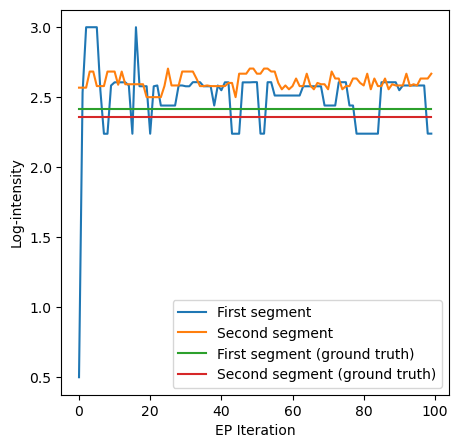

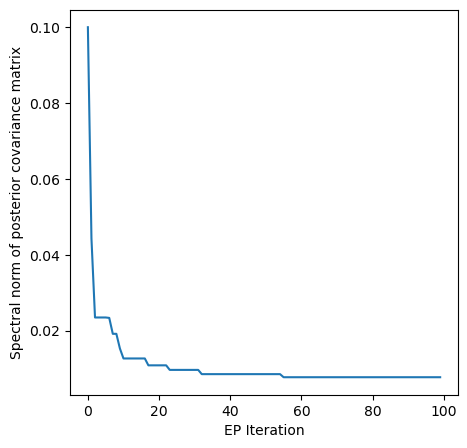

In [27]:
# Plot the historical parameters
plt.figure(figsize=(5, 5))
plt.plot(np.arange(max_ep_iterations), mu_posterior_history[:, 0], label='First segment')
plt.plot(np.arange(max_ep_iterations), mu_posterior_history[:, 1], label='Second segment')
# plt.xticks(np.arange(0, max_ep_iterations, 1))
plt.xlabel('EP Iteration')
plt.ylabel('Log-intensity')
# Show the ground truth
# repeat the ground truth log-intensity for the number of EP iterations
plt.plot(np.arange(max_ep_iterations), np.repeat(log_intensity[0], max_ep_iterations, axis=0), label='First segment (ground truth)')
plt.plot(np.arange(max_ep_iterations), np.repeat(log_intensity[1], max_ep_iterations, axis=0), label='Second segment (ground truth)')
plt.legend()

plt.figure(figsize=(5, 5))
# Plotting the spectral norm of the posterior covariance matrix
plt.plot(np.arange(max_ep_iterations), np.array([np.linalg.eigvals(var_posterior_history[i, :, :])[0] for i in range(max_ep_iterations)]))
plt.xlabel('EP Iteration')
plt.ylabel('Spectral norm of posterior covariance matrix')

tikz_save('ep_convergence.tex', axis_width='9cm', axis_height='9cm')

Text(0, 0.5, 'Spectral norm of posterior covariance matrix')

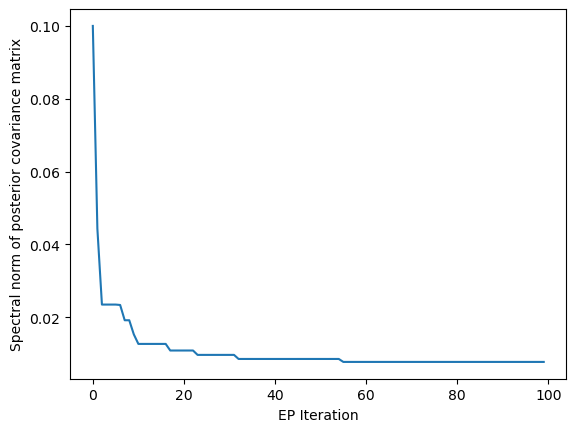

In [ ]:
# Compute the final posterior
q_means_param = np.concatenate((mu_zero.reshape((1,-1)), mu_tildes))
q_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), var_tildes))
mu_q, var_q = gaussian_posterior_update_list(means = q_means_param, vars = q_vars_param)
print('Final posterior mean: {}'.format(mu_q))
plt.plot(mu_zero, 'b', label='Prior')
plt.plot(mu_q, 'r', label='Posterior')
plt.plot(log_intensity, 'g', label='Ground Truth')
plt.xlabel('Segment Index')
plt.ylabel('Log-Intensity')
plt.legend()
# plt.title('Log-Intensity Means: Final Posterior vs Prior vs Ground Truth')

# Demonstration of the Laplace approximation

In [ ]:
from scipy.stats import multivariate_normal

# ==================    Test    ==================
n_samples = 10_000
# uniformly sample from a 2d uniform distribution
particles = np.random.uniform(low=.1, high=5., size=(n_samples, 2))
# Normal-Poisson (the tilted distribution)
normal_poisson = multivariate_normal.pdf(particles, mean=mu_tilde_star, cov=C_tilde_star) * np.exp(nj * particles[:, 1] - A * np.exp(particles[:, 1]))
normal_poisson /= np.sum(normal_poisson)
# The j-excluded normal distribution
normal = multivariate_normal.pdf(particles, mean=mu_tilde_star, cov=C_tilde_star)
normal /= np.sum(normal)
# The imitating distribution by Laplace approximation
imitating = multivariate_normal.pdf(particles, mean=lmean, cov=lvar)
imitating /= np.sum(imitating)

# 3d histogram
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
ax.scatter(particles[:, 0], particles[:, 1], normal_poisson, s=1, c='r')
ax.scatter(particles[:, 0], particles[:, 1], normal, s=1, c='b')
ax.set_title('Normal-Poisson')
ax2 = fig.add_subplot(222, projection='3d')
# ax.scatter(particles[:, 0], particles[:, 1], normal, s=1, c='b')
ax2.scatter(particles[:, 0], particles[:, 1], imitating, s=1, c='g')
ax2.scatter(particles[:, 0], particles[:, 1], normal, s=1, c='b')
ax2.set_title('Imitating')
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(particles[:, 0], particles[:, 1], normal_poisson, s=1, c='r')
ax3.scatter(particles[:, 0], particles[:, 1], imitating, s=1, c='g')
ax3.set_title('Normal-Poisson vs. Imitating')
plt.tight_layout()
plt.show()


So, the imitating distribution approximates the tilted distribution very well. 